In [33]:
from LPIPS_custom.custom_LPIPS import CustomFeatureMetric
import torch
import numpy as np

# It's more efficient to initialize the model once and reuse it.
# This global instance is a good pattern for that.
custom_lpips_model = CustomFeatureMetric(custom_vgg_path='./LPIPS_custom/vgg16_finetuned_3_encoders.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
custom_lpips_model.to(device)

def custom_lpips(img1, img2):
    """
    Computes the LPIPS score using the fine-tuned VGG model.
    Handles numpy array inputs and converts them to the required tensor format.
    """
    # Ensure inputs are tensors and on the correct device
    # The LPIPS model expects input Tensors in shape [B, C, H, W] and range [-1, 1]
    # The model's forward pass handles normalization from [0, 1] to [-1, 1] by default.
    if not isinstance(img1, torch.Tensor):
        img1 = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0).float()
    
    if not isinstance(img2, torch.Tensor):
        img2 = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0).float()

    img1 = img1.to(device)
    img2 = img2.to(device)

    with torch.no_grad(): # Disable gradient calculation for efficiency
        result = custom_lpips_model(img1, img2)

    return round(float(result.item()), 9)

# Test with properly shaped arrays
img0 = np.zeros((64, 64, 3), dtype=np.float32)  # (H, W, C) format
img1 = np.ones((64, 64, 3), dtype=np.float32)   # (H, W, C) format

distance = custom_lpips(img0, img1)
print(f"LPIPS distance with custom VGG: {distance}")

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
LPIPS distance with custom VGG: 0.003005415


In [34]:
# custom vgg
# from LPIPS_custom.custom_perceptual_metric import VGGPerceptualMetric

# perceptual_metric = VGGPerceptualMetric()

# img1 = (np.zeros((224, 224, 3)) * 255).astype(np.uint8)
# img2 = (np.ones((224, 224, 3)) * 255).astype(np.uint8)
# # Calculate distance between different images
# distance1_2 = perceptual_metric.calculate_distance(img1, img2)
# print(f"Perceptual distance between img1 and img2: {distance1_2}")

# from skimage.transform import resize
# def custom_perpetual_metric(img1, img2):
#     """
#     Computes the perceptual distance between two images using a custom VGG-based metric.
#     Handles numpy array inputs and converts them to the required tensor format.
#     """
#     # Ensure inputs are numpy arrays of shape (H, W, 3)
#     if not isinstance(img1, np.ndarray) or not isinstance(img2, np.ndarray):
#         raise ValueError("Both inputs must be numpy arrays of shape (H, W, 3).")
#     if img1.shape != img2.shape or img1.ndim != 3 or img1.shape[2] != 3:
#         raise ValueError("Both images must have the same shape and be in (H, W, 3) format.")
#     # Calculate the perceptual distance using the custom metric
#     # error ValueError: Input 0 of layer "model_7" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 335, 699, 3)
#     # ValueError: Input 0 of layer "model_9" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 335, 699, 3)
#     if img1.shape[0] != 224 or img1.shape[1] != 224:
#         # resize images to (224, 224, 3)
#         img1 = resize(img1, (224, 224), anti_aliasing=True, preserve_range=True)
#         img2 = resize(img2, (224, 224), anti_aliasing=True, preserve_range=True)
#     img1 = img1.astype(np.float32)  # Normalize to [0, 1]
#     img2 = img2.astype(np.float32)  # Normalize to [0, 1]

    # return perceptual_metric.calculate_distance(img1, img2)


In [35]:
import pyiqa
models = pyiqa.list_models() 
print("Available models:")
# for model in models:
#     print(model) 
gmsd_metric = pyiqa.create_metric('gmsd')
print(f'GMSD: {gmsd_metric.lower_better}')
lpips_metric = pyiqa.create_metric('lpips')
print(f'LPIPS: {lpips_metric.lower_better}')


Available models:
GMSD: True
Loading pretrained model LPIPS from /Users/saikirannunemunthala/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth
LPIPS: True


In [36]:
from sewar.full_ref import mse,psnr,rmse_sw,uqi,ssim
# from torchmetrics.functional.image import relative_average_spectral_error
# from torchmetrics.functional.image import spectral_angle_mapper

The most commonly used Metri
 - MSE
 - PSNR
 - SSIM

The metrics that might be relavent
 - RMSE with sliding window
 - Universal Image quality metric
 - Gradient Magnitude Similarity metric 

Learned metric
 - LPIPS


In [37]:
import numpy as np
from scipy import ndimage 
from skimage.metrics import structural_similarity
from skimage.util import img_as_float
from skimage import filters
import warnings
warnings.filterwarnings('ignore')
import cv2
from PIL import Image

def mse_metric(img1, img2) -> float:
    """Mean Squared Error (MSE) - CORRECTED
        output: float - MSE in [0,1], lower is better
    """ 
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8) if img1.dtype != np.uint8 else img1
    img2 = (img2 * 255).astype(np.uint8) if img2.dtype != np.uint8 else img2
    
    return float(mse(img1, img2))

def mae_metric(img1, img2) -> float:
    """Mean Absolute Error (MAE) - Example new metric
        output: float - MAE in [0,1], lower is better
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    
    mae_value = np.mean(np.abs(img1 - img2))
    return float(np.clip(mae_value, 0, 1))

def rmse_sw_metric(img1, img2) -> float:
    """Root Mean Squared Error (RMSE) - CORRECTED
        output: float - RMSE in [0,1], lower is better
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8) if img1.dtype != np.uint8 else img1
    img2 = (img2 * 255).astype(np.uint8) if img2.dtype != np.uint8 else img2
    
    result = rmse_sw(img1, img2)
    # rmse_sw returns a tuple, we want just the rmse_value
    if isinstance(result, tuple):
        return float(result[0])
    return float(result)

def ssim_metric(img1, img2, ws=8) -> float:
    """Structural Similarity Index (2004) - CORRECTED
        output: float - SSIM in [0,1]
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8)
    img2 = (img2 * 255).astype(np.uint8)
    
    result = ssim(img1, img2)
    # ssim returns a tuple (ssim_value, cs_value), we want just the ssim_value
    if isinstance(result, tuple):
        return float(result[0])
    return float(result)
    # ws = min(ws, img1.shape[0]//2, img1.shape[1]//2)
    # if ws < 2:
    #     ws = 2
    # if ws % 2 == 0:
    #     ws += 1
    
    # # Use consistent data range
    # ssim_index = structural_similarity(img1, img2, win_size=ws, data_range=1.0)
    # return float(np.clip(ssim_index, 0, 1))

def psnr_metric(img1, img2) -> float:
    """Peak Signal-to-Noise Ratio (PSNR) - CORRECTED
        output: float - PSNR in dB, higher is better
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100.0  # Set a high but finite value instead of inf
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return float(psnr_value)

def uiqi_metric(img1, img2, ws=8) -> float:
    """Universal Image Quality Index (2002) - CORRECTED
        output: float - UIQI in [0,1]
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8) if img1.dtype != np.uint8 else img1
    img2 = (img2 * 255).astype(np.uint8) if img2.dtype != np.uint8 else img2
    
    result = uqi(img1, img2)
    # uqi might return a tuple, we want just the uqi value
    if isinstance(result, tuple):
        return float(result[0])
    return float(result)
    # ws = min(ws, img1.shape[0]//2, img1.shape[1]//2)
    # if ws < 2:
    #     ws = 2
    # # Ensure odd window size for consistency
    # if ws % 2 == 0:
    #     ws += 1
    
    # mu1 = np.array(ndimage.uniform_filter(img1, size=ws))[ws//2::ws, ws//2::ws]
    # mu2 = np.array(ndimage.uniform_filter(img2, size=ws))[ws//2::ws, ws//2::ws]
    # mu1_sq = np.array(ndimage.uniform_filter(img1*img1, size=ws))[ws//2::ws, ws//2::ws]
    # mu2_sq = np.array(ndimage.uniform_filter(img2*img2, size=ws))[ws//2::ws, ws//2::ws]
    # mu1_mu2 = np.array(ndimage.uniform_filter(img1*img2, size=ws))[ws//2::ws, ws//2::ws]
    
    # sigma1_sq = mu1_sq - mu1 * mu1
    # sigma2_sq = mu2_sq - mu2 * mu2
    # sigma12 = mu1_mu2 - mu1 * mu2
    
    # numerator = 4 * sigma12 * mu1 * mu2
    # denominator = (sigma1_sq + sigma2_sq) * (mu1 * mu1 + mu2 * mu2)
    
    # index = np.ones(denominator.shape)
    # valid_mask = denominator > 0
    # if np.any(valid_mask):
    #     index[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
    
    # score = float(np.mean(index))
    # return np.clip(score, 0, 1)

# def gmsd(img1, img2) -> float:
#     """Gradient Magnitude Similarity Deviation (2014) - CORRECTED
#         output: float - GMSD-based similarity in [0,1] (higher is better)
#     """ 
    
#     # Proper grayscale conversion for BGR images
#     if img1.ndim == 3:
#         img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
#     if img2.ndim == 3:
#         img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    
#     gm1 = np.sqrt(filters.sobel_h(img1)**2 + filters.sobel_v(img1)**2)
#     gm2 = np.sqrt(filters.sobel_h(img2)**2 + filters.sobel_v(img2)**2)
    
#     c = 0.0026
#     gms = (2 * gm1 * gm2 + c) / (gm1**2 + gm2**2 + c)
    
#     gmsd_val = np.std(gms)
#     # Convert GMSD (dissimilarity) to similarity using exponential decay
#     # This is already a similarity measure (higher = more similar)
#     similarity = np.exp(-gmsd_val * 10)
#     return float(np.clip(similarity, 0, 1))


In [38]:
# data_clipped_path = './AirfRANS_clipped'
# data_remeshed_path = './AirfRANS_remeshed'

# import os
# import cv2
# def load_images_from_folder(folder):
#     p_arr = []
#     ux_arr = []
#     uy_arr = [] 
#     for samples in os.listdir(folder):
#         img_path_dir = os.path.join(folder, samples, 'meshes')
#         if not os.path.isdir(img_path_dir):
#             continue
#         for image_path in os.listdir(img_path_dir):
#             img_path = os.path.join(img_path_dir, image_path)
#             if os.path.isfile(img_path) and img_path.endswith('.png'):
#                 filename = os.path.basename(img_path)
#                 if filename.split('_')[-1] == 'p.png':
#                     p_arr.append(img_path)
#                 elif filename.split('_')[-1] == 'ux.png':
#                     ux_arr.append(img_path)
#                 elif filename.split('_')[-1] == 'uy.png':
#                     uy_arr.append(img_path)
#                 continue 
#     return p_arr, ux_arr, uy_arr

# data_clipped = load_images_from_folder(data_clipped_path)
# data_remeshed = load_images_from_folder(data_remeshed_path)

test_csv_path = './LPIPS_custom/test_set_with_new_labels.csv'
image_folder = './LPIPS_custom/raw_data_images/images'
import pandas as pd
import os

data_clipped_p = []
data_clipped_nut = []
data_clipped_ux = []
data_clipped_uy = []

data_remeshed_p = []
data_remeshed_nut = []
data_remeshed_ux = []
data_remeshed_uy = []

df = pd.read_csv(test_csv_path) 
df.set_index('image_name', inplace=True)
image_in_folder = set(os.listdir(image_folder))
for image_name, row in df.iterrows():  
    if image_name in image_in_folder:
        sno, label, field = image_name.split('_')
        img_path = os.path.join(image_folder, image_name)
        if label == 'clipped':
            if field == 'p.png':
                data_clipped_p.append(img_path)
            elif field == 'Ux.png':
                data_clipped_ux.append(img_path)
            elif field == 'Uy.png':
                data_clipped_uy.append(img_path)
            elif field == 'nut.png':
                data_clipped_nut.append(img_path)
        elif label == 'remeshed':
            if field == 'p.png':
                data_remeshed_p.append(img_path)
            elif field == 'Ux.png':
                data_remeshed_ux.append(img_path)
            elif field == 'Uy.png':
                data_remeshed_uy.append(img_path)
            elif field == 'nut.png':
                data_remeshed_nut.append(img_path)
 

# Ensure all lists are sorted to match corresponding images
data_clipped = [data_clipped_p, data_clipped_nut, data_clipped_ux, data_clipped_uy]
data_remeshed = [data_remeshed_p, data_remeshed_nut, data_remeshed_ux, data_remeshed_uy]

min_length = min(len(arr) for arr in data_clipped + data_remeshed)
data_clipped = [arr[:min_length] for arr in data_clipped]
data_remeshed = [arr[:min_length] for arr in data_remeshed]

print("clipped data len:", [len(arr) for arr in data_clipped])
print("remeshed data len:", [len(arr) for arr in data_remeshed]) 



clipped data len: [194, 194, 194, 194]
remeshed data len: [194, 194, 194, 194]


In [ ]:
# DYNAMIC METRIC CONFIGURATION
# Add any new metric here and it will automatically be included in the analysis
from tqdm import tqdm
from joblib import Parallel, delayed

def gmsd_pyiqa_metric(img1, img2) -> float:
    """GMSD metric using PyIQA - handles numpy arrays properly"""
    import torch
    import torchvision.transforms.functional as TF
    
    # Convert numpy arrays to PIL then to tensor
    if isinstance(img1, np.ndarray):
        # Ensure proper format for PIL conversion
        if img1.ndim == 3:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8))
        else:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8), mode='L').convert('RGB')
        img1_tensor = TF.to_tensor(img1_pil).unsqueeze(0)
    
    if isinstance(img2, np.ndarray):
        if img2.ndim == 3:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8))
        else:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8), mode='L').convert('RGB')
        img2_tensor = TF.to_tensor(img2_pil).unsqueeze(0)
    
    # Calculate GMSD
    result = gmsd_metric(img1_tensor, img2_tensor)
    return float(result.item())

def lpips_pyiqa_metric(img1, img2) -> float:
    """LPIPS metric using PyIQA - handles numpy arrays properly"""
    import torch
    import torchvision.transforms.functional as TF
    
    # Convert numpy arrays to PIL then to tensor
    if isinstance(img1, np.ndarray):
        if img1.ndim == 3:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8))
        else:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8), mode='L').convert('RGB')
        img1_tensor = TF.to_tensor(img1_pil).unsqueeze(0)
    
    if isinstance(img2, np.ndarray):
        if img2.ndim == 3:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8))
        else:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8), mode='L').convert('RGB')
        img2_tensor = TF.to_tensor(img2_pil).unsqueeze(0)
    
    # Calculate LPIPS
    result = lpips_metric(img1_tensor, img2_tensor)
    return float(result.item())

metric_funcs = {
    'mse': mse_metric,
    # 'mae': mae_metric,
    # 'rmse_sw': rmse_sw_metric,  # Example new metric
    'ssim': ssim_metric,
    'psnr': psnr_metric,
    # 'uiqi': uiqi_metric,
    'gmsd': gmsd_pyiqa_metric,  # Fixed GMSD function
    'lpips': lpips_pyiqa_metric,  # Fixed LPIPS function
    'lpips-cfd': custom_lpips,  # Custom LPIPS with fine-tuned VGG
    # 'c_perceptual': custom_perpetual_metric,  # Custom perceptual metric with VGG
}

# Metrics that need special normalization (raw value -> [0,1])
NORMALIZATION_RULES = {
    'psnr': lambda x: 1 - np.clip(x / 100, 0, 1),  # PSNR: dB -> [0,1], inverted so 0 is perfect
    'mse': lambda x: np.clip(x / 65025, 0, 1), # MSE: raw -> [0,1], 0 is perfect
    'ssim': lambda x: 1 - x, # SSIM: [0,1] -> [0,1], inverted so 0 is perfect
    'gmsd': lambda x: np.clip(x, 0, 1),
    'lpips': lambda x: np.clip(x, 0, 1),
    'lpips-cfd': lambda x: np.clip(x, 0, 1)
}



def process_single_sample(i, data_clipped, data_remeshed):
    """Processes a single sample of images to calculate IQA metrics."""
    # Load images
    p_clipped = cv2.imread(data_clipped[0][i])
    nut_clipped = cv2.imread(data_clipped[1][i])
    ux_clipped = cv2.imread(data_clipped[2][i])
    uy_clipped = cv2.imread(data_clipped[3][i])
    
    p_remeshed = cv2.imread(data_remeshed[0][i])
    nut_remeshed = cv2.imread(data_remeshed[1][i])
    ux_remeshed = cv2.imread(data_remeshed[2][i])
    uy_remeshed = cv2.imread(data_remeshed[3][i])

    # Ensure images are in float format
    p_clipped = img_as_float(p_clipped)
    nut_clipped = img_as_float(nut_clipped)
    ux_clipped = img_as_float(ux_clipped)
    uy_clipped = img_as_float(uy_clipped)
    p_remeshed = img_as_float(p_remeshed)
    nut_remeshed = img_as_float(nut_remeshed)
    ux_remeshed = img_as_float(ux_remeshed)
    uy_remeshed = img_as_float(uy_remeshed)
    
    # Initialize result dictionaries for this sample
    sample_results_p = {}
    sample_results_nut = {}
    sample_results_ux = {}
    sample_results_uy = {}
    
    # DYNAMIC METRIC CALCULATION
    for metric_name, metric_func in metric_funcs.items():
        # Calculate metrics for all three variables
        metric_p = metric_func(p_clipped, p_remeshed)
        metric_nut = metric_func(nut_clipped, nut_remeshed)
        metric_ux = metric_func(ux_clipped, ux_remeshed)
        metric_uy = metric_func(uy_clipped, uy_remeshed)
        
        # Apply normalization if specified
        if metric_name in NORMALIZATION_RULES:
            normalize_func = NORMALIZATION_RULES[metric_name]
            metric_p = normalize_func(metric_p)
            metric_nut = normalize_func(metric_nut)
            metric_ux = normalize_func(metric_ux)
            metric_uy = normalize_func(metric_uy)
        # Store results with consistent naming
        sample_results_p[f'{metric_name}_p'] = metric_p
        sample_results_nut[f'{metric_name}_nut'] = metric_nut
        sample_results_ux[f'{metric_name}_ux'] = metric_ux
        sample_results_uy[f'{metric_name}_uy'] = metric_uy
        
    return sample_results_p, sample_results_nut, sample_results_ux, sample_results_uy

import time
# DYNAMIC IQA METRICS COMPARISON FUNCTION
def compare_iqa_metrics(data_clipped, data_remeshed, batch_size=50, sample_limit=None, sleep_between_batches=0):
    """
    Compare IQA metrics dynamically using parallel processing.
    
    Automatically includes all metrics defined in metric_funcs dictionary.
    To add a new metric:
    1. Define the metric function
    2. Add it to metric_funcs dictionary
    3. Add normalization rule to NORMALIZATION_RULES if needed
    """
    start_time = time.time()
    
    num_samples = len(data_clipped[0])
    if sample_limit is not None:
        num_samples = min(num_samples, sample_limit)

    metric_names = list(metric_funcs.keys())
    print(f"📊 Computing metrics: {metric_names}")

    all_results = []
    for start_index in tqdm(range(0, num_samples, batch_size), desc="Processing batches"):
        end_index = min(start_index + batch_size, num_samples)
        
        # Process one batch in parallel
        batch_results = Parallel(n_jobs=4)(
            delayed(process_single_sample)(i, data_clipped, data_remeshed)
            for i in range(start_index, end_index)
        )
        all_results.extend(batch_results)
        
        # Optional: Pause between batches to let the CPU cool down
        if sleep_between_batches > 0 and end_index < num_samples:
            print(f"\nBatch finished. Cooling down for {sleep_between_batches} seconds...")
            time.sleep(sleep_between_batches)


    # Unpack results
    results_p = [res[0] for res in all_results]
    results_nut = [res[1] for res in all_results]
    results_ux = [res[2] for res in all_results]
    results_uy = [res[3] for res in all_results]

    end_time = time.time()
    total_time = end_time - start_time
    print(f"⏱️ Total processing time: {total_time:.2f} seconds")
    print(f"⚡ Average time per sample: {total_time/num_samples:.2f} seconds")

    return results_p, results_nut, results_ux, results_uy


In [40]:
# I want to check which metric is taking how much time
sample_limit = 10  # Limit to first 10 samples for quick testing

for metric_name, metric_func in metric_funcs.items():
    start_time = time.time()
    img1 = cv2.imread(data_clipped[0][0])  # Example image from clipped data
    img2 = cv2.imread(data_remeshed[0][0])  # Example image from remeshed data
    # Call the metric function with the current data
    metric_results = metric_func(img1, img2)
    end_time = time.time()
    print(f"⏱️ {metric_name} took {end_time - start_time:.2f} seconds")

⏱️ mse took 0.02 seconds
⏱️ ssim took 0.23 seconds
⏱️ psnr took 0.01 seconds
⏱️ gmsd took 0.02 seconds
⏱️ lpips took 0.07 seconds
⏱️ lpips-cfd took 0.34 seconds


In [41]:
# Run the dynamic function
print("Running dynamic IQA comparison...")
results_p, results_nut, results_ux, results_uy = compare_iqa_metrics(data_clipped, data_remeshed)

Running dynamic IQA comparison...
📊 Computing metrics: ['mse', 'ssim', 'psnr', 'gmsd', 'lpips', 'lpips-cfd']


Processing images:   0%|          | 0/194 [00:00<?, ?it/s]python(76734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing images: 100%|██████████| 194/194 [1:16:57<00:00, 23.80s/it] 


⏱️ Total processing time: 5947.93 seconds
⚡ Average time per sample: 30.66 seconds


In [42]:


# Create DataFrames dynamically
import pandas as pd
results_df_p = pd.DataFrame(results_p)
results_df_nut = pd.DataFrame(results_nut)
results_df_ux = pd.DataFrame(results_ux)
results_df_uy = pd.DataFrame(results_uy)

# DYNAMIC COLUMN RENAMING - automatically handle any number of metrics
def create_display_names(df, suffix):
    """Convert metric_p/metric_ux/metric_uy column names to clean display names"""
    rename_dict = {}
    for col in df.columns:
        # Extract metric name by removing the suffix
        if col.endswith(f'_{suffix}'):
            metric_name = col[:-len(f'_{suffix}')]
            display_name = metric_name.upper()
            rename_dict[col] = display_name
    return rename_dict

# Apply dynamic renaming
results_df_p = results_df_p.rename(columns=create_display_names(results_df_p, 'p'))
results_df_nut = results_df_p.rename(columns=create_display_names(results_df_nut, 'nut'))
results_df_ux = results_df_ux.rename(columns=create_display_names(results_df_ux, 'ux'))
results_df_uy = results_df_uy.rename(columns=create_display_names(results_df_uy, 'uy'))

print("✅ Dynamic calculations completed!")
print(f"📊 Computed {len(results_df_p.columns)} metrics: {list(results_df_p.columns)}")


✅ Dynamic calculations completed!
📊 Computed 6 metrics: ['MSE', 'SSIM', 'PSNR', 'GMSD', 'LPIPS', 'LPIPS-CFD']


In [43]:
print("Pressure Metrics DataFrame:")
results_df_p

Pressure Metrics DataFrame:


,MSE,SSIM,PSNR,GMSD,LPIPS,LPIPS-CFD
0,0.001407,0.013772,0.714816,0.039443,0.032281,0.000021
1,0.001899,0.122189,0.727851,0.045994,0.043522,0.000047
2,0.194250,0.811595,0.928836,0.037583,0.666324,0.001849
3,0.004950,0.243345,0.769458,0.061517,0.100195,0.000111
4,0.010144,0.379313,0.800621,0.052090,0.156110,0.000284
...,...,...,...,...,...,...
189,0.003603,0.209987,0.755663,0.052419,0.069660,0.000100
190,0.020133,0.256826,0.830391,0.044059,0.150366,0.000177
191,0.000294,0.008535,0.646852,0.028266,0.014162,0.000005
192,0.002854,0.153050,0.745542,0.057549,0.149468,0.000225


In [44]:
print(f"Nut Metrics DataFrame:")
results_df_nut

Nut Metrics DataFrame:


,MSE,SSIM,PSNR,GMSD,LPIPS,LPIPS-CFD
0,0.001407,0.013772,0.714816,0.039443,0.032281,0.000021
1,0.001899,0.122189,0.727851,0.045994,0.043522,0.000047
2,0.194250,0.811595,0.928836,0.037583,0.666324,0.001849
3,0.004950,0.243345,0.769458,0.061517,0.100195,0.000111
4,0.010144,0.379313,0.800621,0.052090,0.156110,0.000284
...,...,...,...,...,...,...
189,0.003603,0.209987,0.755663,0.052419,0.069660,0.000100
190,0.020133,0.256826,0.830391,0.044059,0.150366,0.000177
191,0.000294,0.008535,0.646852,0.028266,0.014162,0.000005
192,0.002854,0.153050,0.745542,0.057549,0.149468,0.000225


In [45]:
print("Velocity X Metrics DataFrame:")
results_df_ux

Velocity X Metrics DataFrame:


,MSE,SSIM,PSNR,GMSD,LPIPS,LPIPS-CFD
0,0.005338,0.065407,0.772735,0.091462,0.115524,0.000083
1,0.003606,0.056117,0.755707,0.065867,0.064226,0.000046
2,0.019415,0.196698,0.828814,0.067590,0.178559,0.000197
3,0.003752,0.056651,0.757426,0.103769,0.073955,0.000087
4,0.000908,0.026793,0.695807,0.063363,0.026362,0.000026
...,...,...,...,...,...,...
189,0.014095,0.266064,0.814908,0.056721,0.118575,0.000136
190,0.008671,0.040977,0.793806,0.055888,0.068072,0.000169
191,0.000827,0.014477,0.691761,0.035788,0.016144,0.000018
192,0.004801,0.052353,0.768131,0.095996,0.071425,0.000109


In [46]:
print("Velocity Y Metrics DataFrame:")
results_df_uy

Velocity Y Metrics DataFrame:


,MSE,SSIM,PSNR,GMSD,LPIPS,LPIPS-CFD
0,0.339642,0.799808,0.953102,0.067621,0.520327,0.002988
1,0.272569,0.679339,0.943548,0.065949,0.450978,0.002305
2,0.233129,0.789432,0.936760,0.058250,0.519673,0.002575
3,0.102349,0.382589,0.901008,0.052715,0.566753,0.003256
4,0.163529,0.724817,0.921359,0.049333,0.396752,0.001704
...,...,...,...,...,...,...
189,0.129128,0.529456,0.911102,0.036281,0.568129,0.001232
190,0.135714,0.675808,0.913262,0.056731,0.353534,0.001457
191,0.200294,0.698701,0.930167,0.055934,0.414157,0.001859
192,0.010697,0.081558,0.802928,0.058706,0.072515,0.000129


In [4]:
# save the df in files
results_folder = './test_results'
import os
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


p_results_df_path = f'{results_folder}/results_pressure.csv'
nut_results_df_path = f'{results_folder}/results_nut.csv'
ux_results_df_path = f'{results_folder}/results_velocity_x.csv'
uy_results_df_path = f'{results_folder}/results_velocity_y.csv'

# save the results to CSV files
# results_df_p.to_csv(p_results_df_path, index=False)
# results_df_nut.to_csv(nut_results_df_path, index=False)
# results_df_ux.to_csv(ux_results_df_path, index=False)
# results_df_uy.to_csv(uy_results_df_path, index=False)

# Load the results from CSV files
import pandas as pd
import numpy as np
results_df_p = pd.read_csv(p_results_df_path)
results_df_nut = pd.read_csv(nut_results_df_path)
results_df_ux = pd.read_csv(ux_results_df_path)
results_df_uy = pd.read_csv(uy_results_df_path)

Comparison of highest and lowest values:
Pressure Metrics:
                 max       min  fold_change
MSE        0.325062  0.000139  2331.537526
SSIM       0.847138  0.007858   107.809412
PSNR       0.951197  0.614432     1.548090
GMSD       0.084170  0.016475     5.108823
LPIPS      0.818979  0.005063   161.763064
LPIPS-CFD  0.005491  0.000002  2801.365306
Nut Metrics:
                 max       min  fold_change
MSE        0.325062  0.000139  2331.537526
SSIM       0.847138  0.007858   107.809412
PSNR       0.951197  0.614432     1.548090
GMSD       0.084170  0.016475     5.108823
LPIPS      0.818979  0.005063   161.763064
LPIPS-CFD  0.005491  0.000002  2801.365306
UX Metrics:
                 max           min  fold_change
MSE        0.164994  2.607377e-05  6327.977698
SSIM       0.665242  4.197939e-03   158.468821
PSNR       0.921747  5.416204e-01     1.701832
GMSD       0.126823  8.310379e-03    15.260852
LPIPS      0.600435  1.543551e-03   388.995707
LPIPS-CFD  0.001653  8.290000

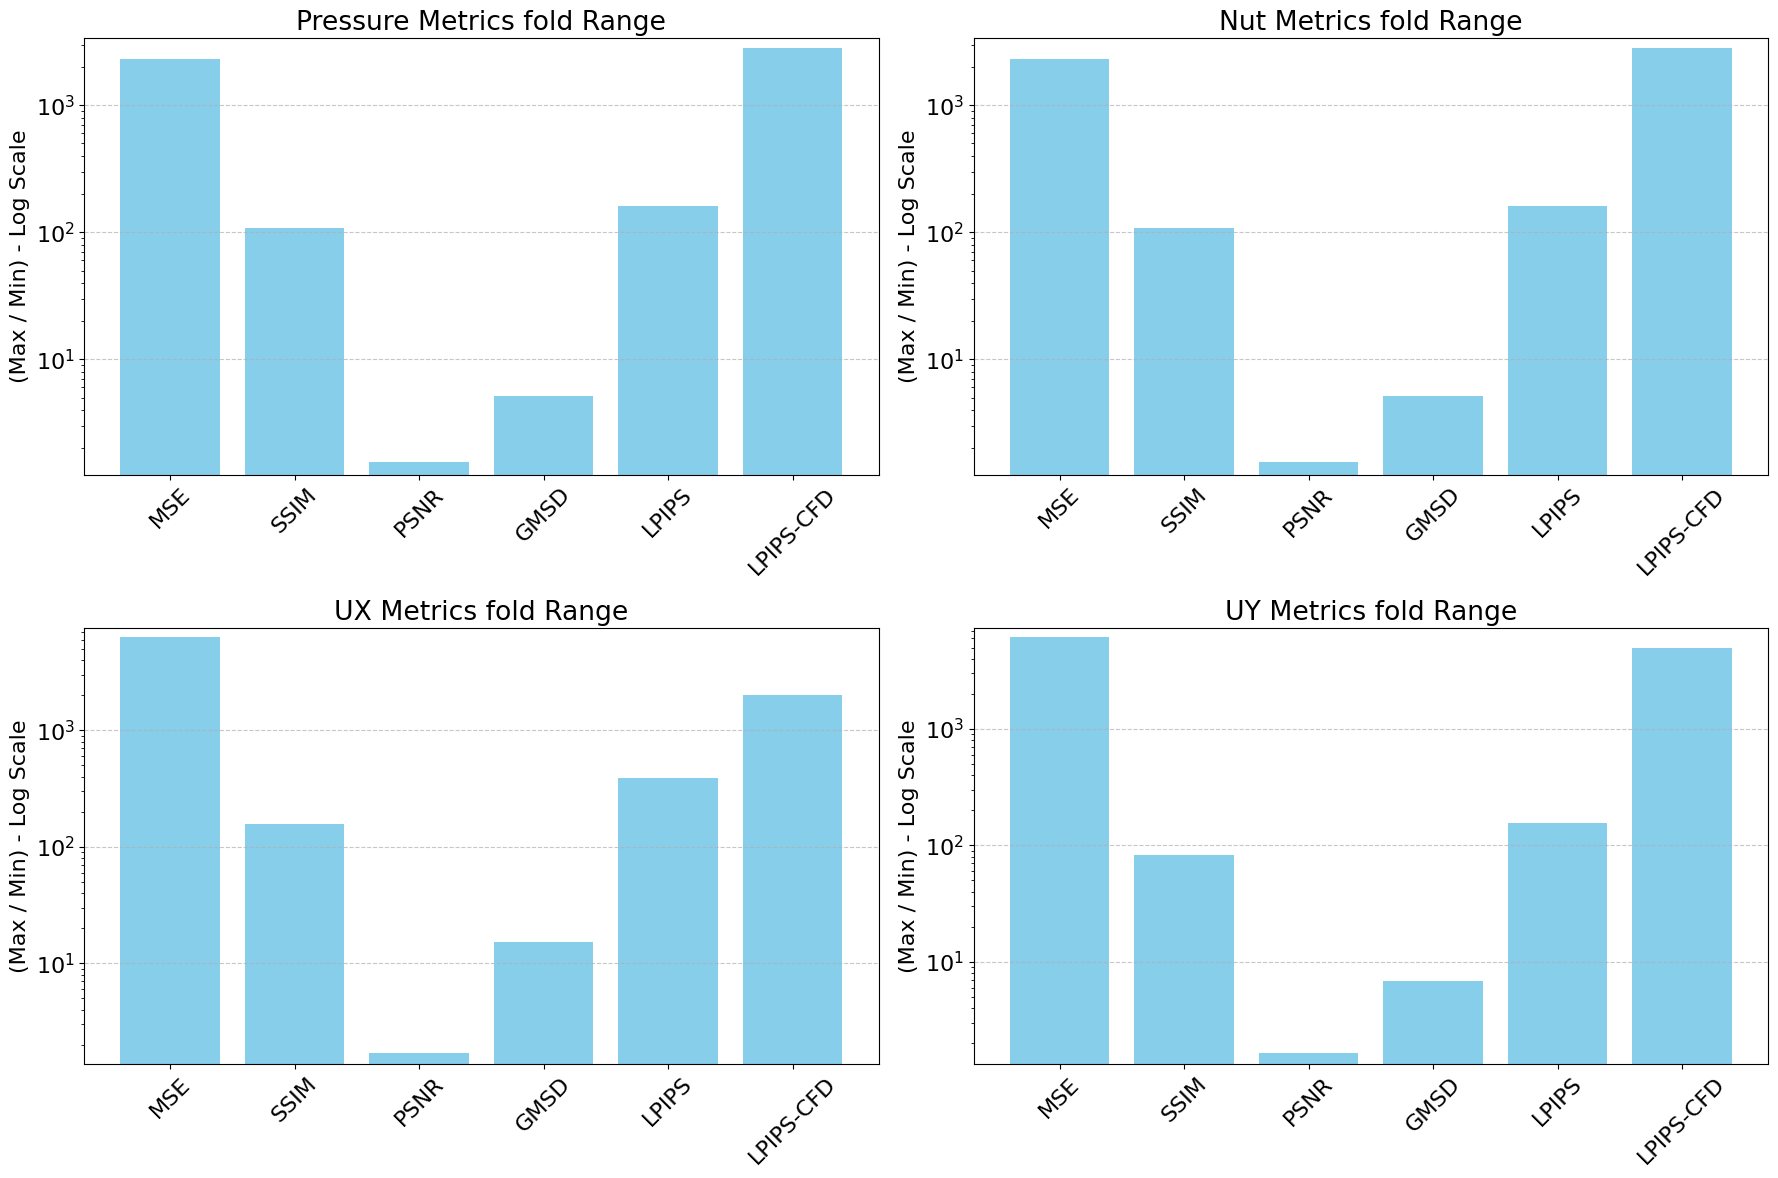

In [5]:
# compare highest and lowest values
def compare_sensitivity(df):
    """Calculate sensitivity metrics for each column of the DataFrame."""
    comparison = {}
    for col in df.columns:
        max_value = df[col].max()
        min_value = df[col].min()
        std_dev = df[col].std()
        comparison[col] = {
            'max': max_value,
            'min': min_value,
            # 'dynamic_range': max_value - min_value, # More meaningful than fold change
            # 'std_dev': std_dev, # Excellent measure of score spread
            'fold_change': max_value / min_value if min_value != 0 else np.inf
        }
    return pd.DataFrame(comparison).T

comparison_p = compare_sensitivity(results_df_p)
comparison_nut = compare_sensitivity(results_df_nut)
comparison_ux = compare_sensitivity(results_df_ux)
comparison_uy = compare_sensitivity(results_df_uy)
print("Comparison of highest and lowest values:")
print("Pressure Metrics:\n", comparison_p)
print("Nut Metrics:\n", comparison_nut)
print("UX Metrics:\n", comparison_ux)
print("UY Metrics:\n", comparison_uy)
import matplotlib.pyplot as plt 

# Display only the difference values in a bar plot
def plot_difference(comparison_df, title, ax, key='dynamic_range', xlabel='', ylabel='Dynamic Range (Max - Min) - Log Scale'):
    """Plot the difference dynamic_range from the comparison DataFrame with logarithmic scale""" 
    ax.set_title(title)
    ax.bar(comparison_df.index, comparison_df[key], color='skyblue')
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel) 
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set logarithmic scale for y-axis
    ax.set_yscale('log')

    ax.tick_params(axis='x', rotation=45)
    
    # Handle potential infinite values before setting y-limit
    finite_max = comparison_df.loc[np.isfinite(comparison_df[key]), key].max()
    finite_min = comparison_df.loc[np.isfinite(comparison_df[key]), key].min()
    
    if pd.notna(finite_max) and pd.notna(finite_min) and finite_max > 0 and finite_min > 0:
        ax.set_ylim(finite_min * 0.8, finite_max * 1.2)  # Add some space above and below

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# plot font size increase for this plot
plt.rcParams.update({'font.size': 16})


plot_difference(comparison_p, 'Pressure Metrics fold Range', axes[0, 0], key='fold_change', xlabel='', ylabel='(Max / Min) - Log Scale')
plot_difference(comparison_nut, 'Nut Metrics fold Range', axes[0, 1], key='fold_change', xlabel='', ylabel='(Max / Min) - Log Scale')
plot_difference(comparison_ux, 'UX Metrics fold Range', axes[1, 0], key='fold_change', xlabel='', ylabel='(Max / Min) - Log Scale')
plot_difference(comparison_uy, 'UY Metrics fold Range', axes[1, 1], key='fold_change', xlabel='', ylabel='(Max / Min) - Log Scale')
# font size increase for all plots
plt.rcParams.update({'font.size': 14})
plt.tight_layout()  # Apply tight layout to the whole figure
plt.show()


# fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# # plot font size increase for this plot
# plt.rcParams.update({'font.size': 16})


# plot_difference(comparison_p, 'Pressure Metrics Dynamic Range', axes[0, 0], key='dynamic_range', xlabel='', ylabel='Dynamic Range (Max - Min) - Log Scale')
# plot_difference(comparison_nut, 'Nut Metrics Dynamic Range', axes[0, 1], key='dynamic_range', xlabel='', ylabel='Dynamic Range (Max - Min) - Log Scale')
# plot_difference(comparison_ux, 'UX Metrics Dynamic Range', axes[1, 0], key='dynamic_range', xlabel='', ylabel='Dynamic Range (Max - Min) - Log Scale')
# plot_difference(comparison_uy, 'UY Metrics Dynamic Range', axes[1, 1], key='dynamic_range', xlabel='', ylabel='Dynamic Range (Max - Min) - Log Scale')
# # font size increase for all plots
# plt.rcParams.update({'font.size': 14})
# plt.tight_layout()  # Apply tight layout to the whole figure
# plt.show()

# fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# # plot font size increase for this plot
# plt.rcParams.update({'font.size': 16})


# plot_difference(comparison_p, 'Pressure Metrics std_dev Range', axes[0, 0], key='std_dev', xlabel='', ylabel='Standard Deviation Range - Log Scale')
# plot_difference(comparison_nut, 'Nut Metrics std_dev Range', axes[0, 1], key='std_dev', xlabel='', ylabel='Standard Deviation Range - Log Scale')
# plot_difference(comparison_ux, 'UX Metrics std_dev Range', axes[1, 0], key='std_dev', xlabel='', ylabel='Standard Deviation Range - Log Scale')
# plot_difference(comparison_uy, 'UY Metrics std_dev Range', axes[1, 1], key='std_dev', xlabel='', ylabel='Standard Deviation Range - Log Scale')
# # font size increase for all plots
# plt.rcParams.update({'font.size': 22})
# plt.tight_layout()  # Apply tight layout to the whole figure
# plt.show()


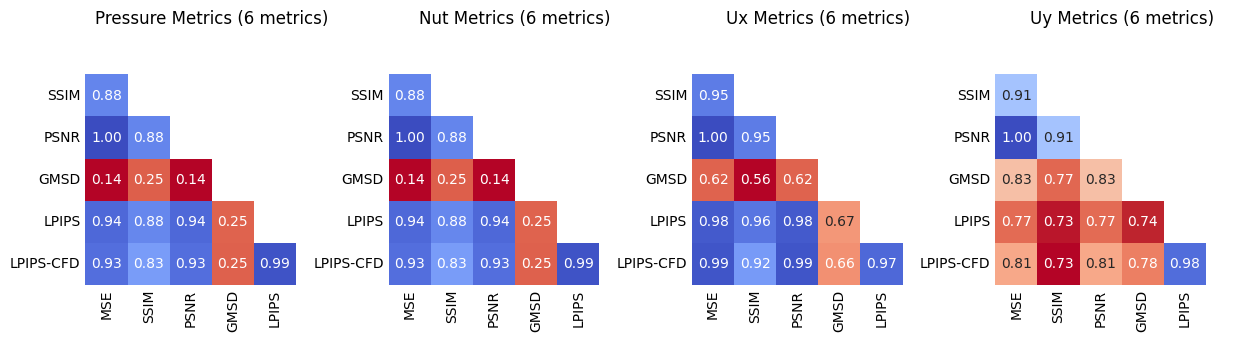


DYNAMIC IQA SYSTEM STATUS:
✅ Computed 6 metrics: ['MSE', 'SSIM', 'PSNR', 'GMSD', 'LPIPS', 'LPIPS-CFD']
✅ All metrics normalized to [0,1] scale
✅ Dynamic correlation visualization
✅ Ready to add new metrics!


In [50]:
# DYNAMIC CORRELATION VISUALIZATION

import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
corr_method = 'spearman'
# Automatically adjust figure size based on number of metrics
n_metrics = len(results_df_p.columns)
fig_width = max(15, n_metrics * 2)  # Minimum 15, scale with metrics
fig, axes = plt.subplots(1, 4, figsize=(fig_width, 5))
def hide_corners(ax):
    # Hide first metric (MSE) from y-axis and last metric (LPIPS-CFD) from x-axis
    y_labels = ax.get_yticklabels()
    x_labels = ax.get_xticklabels()
    if len(y_labels) > 0:
        y_labels[0].set_visible(False)  # Hide first y-label (MSE)
    if len(x_labels) > 0:
        x_labels[-1].set_visible(False)  # Hide last x-label (LPIPS-CFD)
    # hide tick lines
    ax.tick_params(axis='both', which='both', length=0)

# Pressure
sns.heatmap(results_df_p.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_p.corr(method=corr_method), dtype=bool)), ax=axes[0])
axes[0].set_title(f'Pressure Metrics ({n_metrics} metrics)') 
if len(axes[0].collections) > 0:
    axes[0].collections[0].colorbar.remove()


# Nut
sns.heatmap(results_df_nut.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_nut.corr(method=corr_method), dtype=bool)), ax=axes[1])
axes[1].set_title(f'Nut Metrics ({n_metrics} metrics)')
if len(axes[1].collections) > 0:
    axes[1].collections[0].colorbar.remove() 
# Ux
sns.heatmap(results_df_ux.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_ux.corr(method=corr_method), dtype=bool)), ax=axes[2])
axes[2].set_title(f'Ux Metrics ({n_metrics} metrics)')
if len(axes[2].collections) > 0:
    axes[2].collections[0].colorbar.remove()

# Uy
sns.heatmap(results_df_uy.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_uy.corr(method=corr_method), dtype=bool)), ax=axes[3])
axes[3].set_title(f'Uy Metrics ({n_metrics} metrics)')
if len(axes[3].collections) > 0:
    axes[3].collections[0].colorbar.remove()

hide_corners(axes[0])
hide_corners(axes[1])
hide_corners(axes[2])
hide_corners(axes[3])

plt.rcParams.update({'font.size': 10}) 
plt.show()

# Print summary of what's computed
print("\n" + "="*60)
print("DYNAMIC IQA SYSTEM STATUS:")
print("="*60)
print(f"✅ Computed {n_metrics} metrics: {list(results_df_p.columns)}")
print(f"✅ All metrics normalized to [0,1] scale")
print(f"✅ Dynamic correlation visualization")
print(f"✅ Ready to add new metrics!")
print("="*60)

In [51]:
# print correlation matrices
print("\nPressure Metrics Correlation Matrix:")
print(results_df_p.corr())
print("\nNut Metrics Correlation Matrix:")
print(results_df_nut.corr())
print("\nUx Metrics Correlation Matrix:")   
print(results_df_ux.corr())
print("\nUy Metrics Correlation Matrix:")
print(results_df_uy.corr()) 


Pressure Metrics Correlation Matrix:
                MSE      SSIM      PSNR      GMSD     LPIPS  LPIPS-CFD
MSE        1.000000  0.848817  0.835147  0.175568  0.922688   0.846550
SSIM       0.848817  1.000000  0.854026  0.203904  0.870603   0.700363
PSNR       0.835147  0.854026  1.000000  0.161437  0.899433   0.750307
GMSD       0.175568  0.203904  0.161437  1.000000  0.233627   0.258730
LPIPS      0.922688  0.870603  0.899433  0.233627  1.000000   0.911551
LPIPS-CFD  0.846550  0.700363  0.750307  0.258730  0.911551   1.000000

Nut Metrics Correlation Matrix:
                MSE      SSIM      PSNR      GMSD     LPIPS  LPIPS-CFD
MSE        1.000000  0.848817  0.835147  0.175568  0.922688   0.846550
SSIM       0.848817  1.000000  0.854026  0.203904  0.870603   0.700363
PSNR       0.835147  0.854026  1.000000  0.161437  0.899433   0.750307
GMSD       0.175568  0.203904  0.161437  1.000000  0.233627   0.258730
LPIPS      0.922688  0.870603  0.899433  0.233627  1.000000   0.911551
LPIPS-

Making sure the Custom LPIPS results are good

In [52]:
# This is to just test on the same images to see if the metrics are working correctly by giving a perfect score
print("\nRunning dynamic IQA comparison on the same images...") 
results_p_same, results_nut_same, results_ux_same, results_uy_same = compare_iqa_metrics(data_clipped, data_clipped, sample_limit=2)


Running dynamic IQA comparison on the same images...
📊 Computing metrics: ['mse', 'ssim', 'psnr', 'gmsd', 'lpips', 'lpips-cfd']


Processing images: 100%|██████████| 2/2 [00:00<00:00, 550.51it/s]


⏱️ Total processing time: 7.93 seconds
⚡ Average time per sample: 3.97 seconds


In [53]:

results_df_p_same = pd.DataFrame(results_p_same)
results_df_p_same

,mse_p,ssim_p,psnr_p,gmsd_p,lpips_p,lpips-cfd_p
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

results_df_ux_same = pd.DataFrame(results_ux_same)
results_df_ux_same

,mse_ux,ssim_ux,psnr_ux,gmsd_ux,lpips_ux,lpips-cfd_ux
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

results_df_uy_same = pd.DataFrame(results_uy_same)
results_df_uy_same

,mse_uy,ssim_uy,psnr_uy,gmsd_uy,lpips_uy,lpips-cfd_uy
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# read file coefficient_comparison_results
import pandas as pd
comparison_results = pd.read_csv('coefficient_comparison_results.csv')
comparison_results = comparison_results.set_index('sample')

In [55]:
data_clipped_path = './AirfRANS_clipped' 
samples_arr = []
for samples in os.listdir(data_clipped_path):
    img_path_dir = os.path.join(data_clipped_path, samples) 
    if samples.startswith('sample_'):
        samples_arr.append(samples)


In [56]:
scalar_results_df_p = results_df_p.copy()
scalar_results_df_nut = results_df_nut.copy()
scalar_results_df_ux = results_df_ux.copy()
scalar_results_df_uy = results_df_uy.copy()

for i, sample_name in enumerate(samples_arr):
    # find sample_name in comparison_results
    if sample_name in comparison_results.index:
        sample_row = comparison_results.loc[sample_name]
        values = sample_row.to_dict()
        # find results_df_p[i] 
        scalar_results_df_p.at[i, 's_diff'] = values['pressure_drag_diff_percent']
        scalar_results_df_nut.at[i, 's_diff'] = values['viscous_drag_diff_percent']
        scalar_results_df_ux.at[i, 's_diff'] = values['cd_diff_percent']
        scalar_results_df_uy.at[i, 's_diff'] = values['cl_diff_percent']
    else:
        print(f"Sample {sample_name} not found in comparison_results") 

In [57]:
print("\nPressure Metrics with Scalar Differences correlation matrix:")
print(scalar_results_df_p.corr())
print("\nNut Metrics with Scalar Differences correlation matrix:")
print(scalar_results_df_nut.corr())
print("\nUx Metrics with Scalar Differences correlation matrix:")
print(scalar_results_df_ux.corr())
print("\nUy Metrics with Scalar Differences correlation matrix:")
print(scalar_results_df_uy.corr())


Pressure Metrics with Scalar Differences correlation matrix:
                MSE      SSIM      PSNR      GMSD     LPIPS  LPIPS-CFD  \
MSE        1.000000  0.848817  0.835147  0.175568  0.922688   0.846550   
SSIM       0.848817  1.000000  0.854026  0.203904  0.870603   0.700363   
PSNR       0.835147  0.854026  1.000000  0.161437  0.899433   0.750307   
GMSD       0.175568  0.203904  0.161437  1.000000  0.233627   0.258730   
LPIPS      0.922688  0.870603  0.899433  0.233627  1.000000   0.911551   
LPIPS-CFD  0.846550  0.700363  0.750307  0.258730  0.911551   1.000000   
s_diff     0.199496  0.162788  0.051136  0.160314  0.141037   0.186135   

             s_diff  
MSE        0.199496  
SSIM       0.162788  
PSNR       0.051136  
GMSD       0.160314  
LPIPS      0.141037  
LPIPS-CFD  0.186135  
s_diff     1.000000  

Nut Metrics with Scalar Differences correlation matrix:
                MSE      SSIM      PSNR      GMSD     LPIPS  LPIPS-CFD  \
MSE        1.000000  0.848817  0.83514

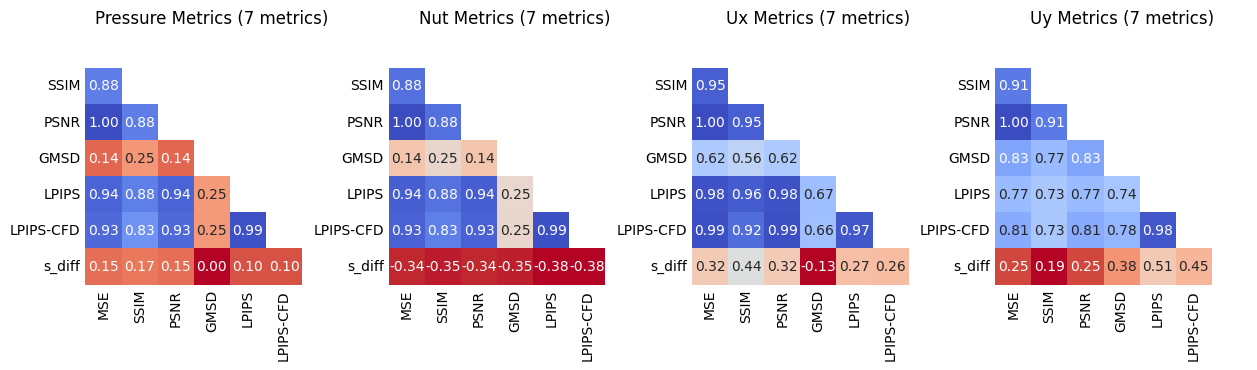

: 

In [ ]:
# DYNAMIC CORRELATION VISUALIZATION

import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
corr_method = 'spearman'
# Automatically adjust figure size based on number of metrics
n_metrics = len(scalar_results_df_p.columns)
fig_width = max(15, n_metrics * 2)  # Minimum 15, scale with metrics
fig, axes = plt.subplots(1, 4, figsize=(fig_width, 5))

# Pressure
sns.heatmap(scalar_results_df_p.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(scalar_results_df_p.corr(method=corr_method), dtype=bool)), ax=axes[0])
axes[0].set_title(f'Pressure Metrics ({n_metrics} metrics)') 
if len(axes[0].collections) > 0:
    axes[0].collections[0].colorbar.remove()

# Nut
sns.heatmap(scalar_results_df_nut.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(scalar_results_df_nut.corr(method=corr_method), dtype=bool)), ax=axes[1])
axes[1].set_title(f'Nut Metrics ({n_metrics} metrics)')
if len(axes[1].collections) > 0:
    axes[1].collections[0].colorbar.remove()

# Ux
sns.heatmap(scalar_results_df_ux.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(scalar_results_df_ux.corr(method=corr_method), dtype=bool)), ax=axes[2])
axes[2].set_title(f'Ux Metrics ({n_metrics} metrics)')
if len(axes[2].collections) > 0:
    axes[2].collections[0].colorbar.remove()

# Uy
sns.heatmap(scalar_results_df_uy.corr(method=corr_method), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(scalar_results_df_uy.corr(method=corr_method), dtype=bool)), ax=axes[3])
axes[3].set_title(f'Uy Metrics ({n_metrics} metrics)')
if len(axes[3].collections) > 0:
    axes[3].collections[0].colorbar.remove()

hide_corners(axes[0])
hide_corners(axes[1])
hide_corners(axes[2])
hide_corners(axes[3])

plt.rcParams.update({'font.size': 10}) 
plt.show()